In [3]:
from oipd import RND, MarketInputs, ModelParams
import matplotlib.pyplot as plt
from datetime import date

['2025-10-03', '2025-10-10', '2025-10-17', '2025-10-24', '2025-10-31', '2025-11-07', '2025-11-21', '2026-01-16', '2026-04-17', '2026-06-18', '2026-10-16', '2027-01-15', '2027-09-17', '2027-12-17', '2028-01-21']
Underlying price 26.4200 (source: vendor), implied forward price 26.6077; dividends: none, forward-implied annualised dividend yield of 1.8450%; days_to_expiry=111; r=0.04172416373638514;


/Users/henrytian/Library/CloudStorage/OneDrive-Personal/Documents/2_Projects/Github/probabilistic/oipd/core/prep.py:57: UserWarning: Filtered 8 strikes older than 3 days (most recent: 1 days old, oldest: 54 days old)
  warnings.warn(


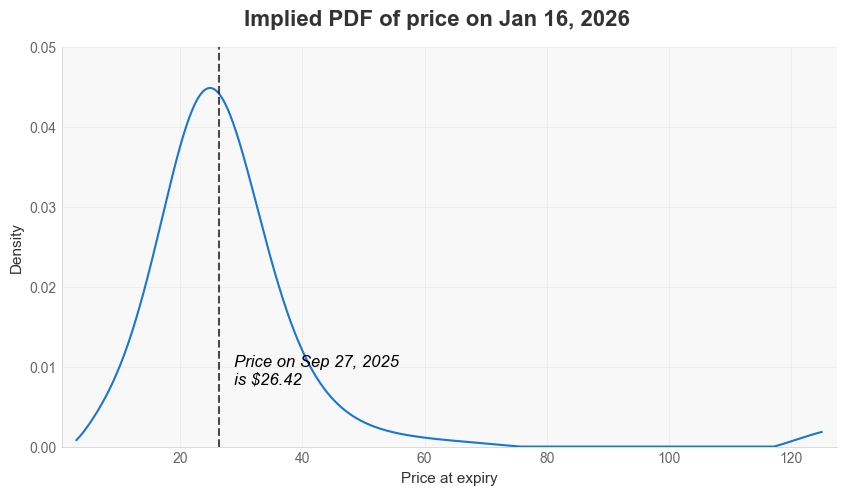

'Underlying price 26.4200 (source: vendor), implied forward price 26.6077; dividends: none, forward-implied annualised dividend yield of 1.8450%; days_to_expiry=111; r=0.04172416373638514;'

In [4]:
# --- Example 1 - GME --- #
# --- using yfinance connection --- #

# 1. Get a list of available expiry dates
expiry_dates = RND.list_expiry_dates("GME")
print(expiry_dates[:])  # ['2025-09-05', '2025-09-12', '2025-09-19',...]

# 2. Use ticker data with market parameters (current price fetched automatically)
market = MarketInputs(
    valuation_date=date.today(),
    expiry_date=date(2026, 1, 16),
    risk_free_rate=0.04199, # US 3-month nominal Treasury yield
)

# 3. Fetch and estimate - auto-fetched data is available in the result
est_gamestop = RND.from_ticker("GME", market)

# 4. Check the final market parameters used in estimation
est_gamestop.market

# 5. Plot using the result object
est_gamestop.plot(kind='pdf') # optional: `kind="pdf"` or `kind="cdf"`
plt.show()

# 6. Access results
# probability of price at or above a certain level
est_gamestop.prob_at_or_above(100)

# probability of price below a certain level
est_gamestop.prob_below(100)

# get results as a dataframe
est_gamestop.to_frame()

# see all the parameters that were used in the estimation
est_gamestop.summary()


/Users/henrytian/Library/CloudStorage/OneDrive-Personal/Documents/2_Projects/Github/probabilistic/oipd/io/reader.py:92: UserWarning: Optional columns not present: {'last_trade_date'}.
  warnings.warn(


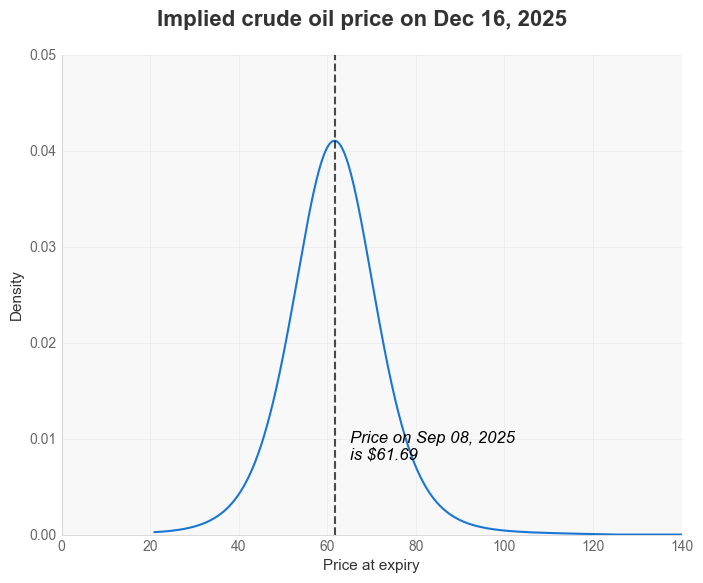

1.0


In [5]:
# --- Example 2 - Crude Oil WTI --- #
# --- using csv file --- #

#  1. Column mapping (CSV headers → OIPD fields)
column_mapping_wti = {
    "Strike": "strike",
    "Last": "last_price",
    "Bid": "bid",
    "Ask": "ask",
    "Type": "option_type",
}

# 2. market parameters
market_wti = MarketInputs(
    underlying_price=61.69,  # current price of the underlying instrument on valuation date
    valuation_date=date(2025, 9, 8),
    expiry_date=date(2025, 12, 16),
    risk_free_rate=0.04199,  # US 3-month nominal Treasury yield
)

# 3. optional model knobs (could omit)
model_wti = ModelParams(
    solver="brent", price_method="mid", max_staleness_days=None
)

# 4. run using WTI options chain
est_wti = RND.from_csv(
    "data/WTIfutures_date250908exp251216_spot6169.csv",
    market_wti,
    model=model_wti,
    column_mapping=column_mapping_wti,
)

# PDF only
fig = est_wti.plot(
    kind="pdf",
    figsize=(8, 6),
    xlim=(0, 140),
    title="Implied crude oil price on Dec 16, 2025",
)
plt.show()

prob = est_wti.prob_below(200)
print(prob)

/Users/henrytian/Library/CloudStorage/OneDrive-Personal/Documents/2_Projects/Github/probabilistic/oipd/io/reader.py:92: UserWarning: Optional columns not present: {'last_trade_date'}.
  warnings.warn(
/Users/henrytian/Library/CloudStorage/OneDrive-Personal/Documents/2_Projects/Github/probabilistic/oipd/core/prep.py:108: UserWarning: Filled missing mid prices with last_price due to unavailable bid/ask
  warnings.warn(


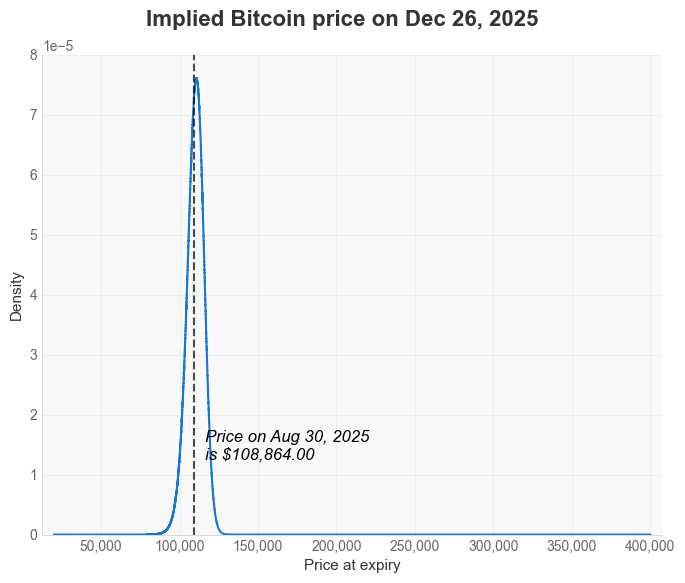

9.385850689547226e-06

In [6]:
# --- Example 3 - Bitcoin --- # 
# options data from Deribit BTC-USDC
# https://www.deribit.com/options/BTC_USDC

#     strike , last_price , bid , ask
column_mapping_bitcoin = {
    "Strike": "strike",
    "Last": "last_price",
    "Bid": "bid",
    "Ask": "ask",
    "OptionType": "option_type",
}

# 2️⃣  market parameters
market_bitcoin = MarketInputs(
    underlying_price=108864,  # current price of the underlying instrument
    valuation_date=date(2025, 8, 30),
    expiry_date=date(2025, 12, 26),
    risk_free_rate=0.04199,  # US 3-month nominal Treasury yield
)

# 3️⃣  optional model knobs (could omit)
model_bitcoin = ModelParams(price_method="mid", max_staleness_days=None)

# 4️⃣  run using S&P500 e-mini futures options chain
est_bitcoin = RND.from_csv(
    "data/bitcoin_date20250830_strike20251226_price108864.csv",
    market_bitcoin,
    model=model_bitcoin,
    column_mapping=column_mapping_bitcoin,
)

# PDF only
fig = est_bitcoin.plot(
    kind="pdf",
    figsize=(8, 6),
    title="Implied Bitcoin price on Dec 26, 2025",
)
plt.show()

est_bitcoin.prob_at_or_above(130000)

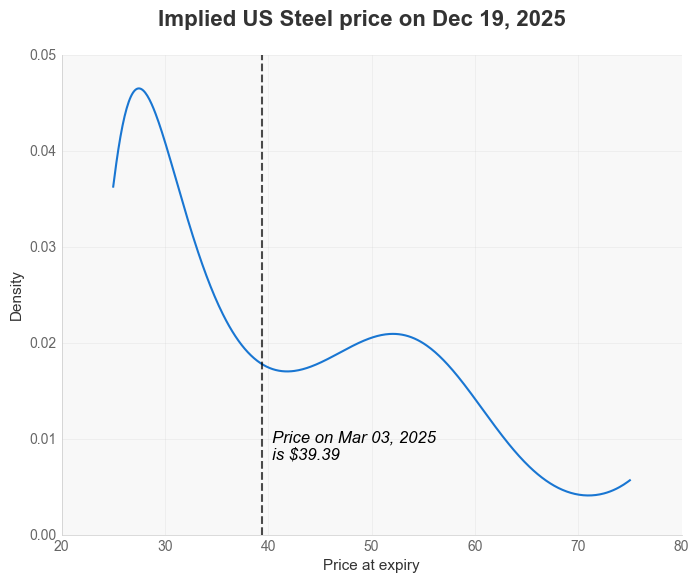

0.21170559709530723


In [7]:
# --- Example 4 - US Steel --- # 
# Note I only saved the data for calls, missing puts

# 1) column mapping (CSV headers → OIPD fields)
column_mapping_us_steel = {
    "Strike": "strike",
    "Last Price": "last_price",
    "Bid": "bid",
    "Ask": "ask",
    "Last Trade Date (EST)": "last_trade_date",
    # No option_type column in this CSV
}

# 2) market parameters
market_us_steel = MarketInputs(
    underlying_price=39.39,
    valuation_date=date(2025, 3, 3),
    expiry_date=date(2025, 12, 19),
    risk_free_rate=0.04199,
)

# 3) optional model knobs (Black–Scholes for equity)
model_us_steel = ModelParams(
    pricing_engine="bs",
    solver="brent",
    price_method="mid",
    max_staleness_days=None,
)

# 4) run using US Steel options chain (CSV)
est_us_steel = RND.from_csv(
    "data/ussteel_date20250303_strike20251219_price3939.csv",
    market_us_steel,
    model=model_us_steel,
    column_mapping=column_mapping_us_steel,
)

# Plot PDF
fig = est_us_steel.plot(
    kind="pdf",
    figsize=(8, 6),
    xlim=(20, 80),
    title="Implied US Steel price on Dec 19, 2025",
)
plt.show()

# Example probability query
prob = est_us_steel.prob_at_or_above(55)
print(prob)



### Back in Mar 2025, US Steel was an interesting example. 

The distribution is bimodal, and given Nippon Steel's proposed $55 per share acquisition, it can be thought of as two overlapping scenarios:

1. Acquisition is approved:
    - In this scenario, the share price would likely move above the $55 per share offer. This creates a "second peak" in the distribution
    - By inspecting the cumulative probability, we see there's a 21% probability that the deal is approved and price rises above $55

2. Acquisition falls apart:
    - Without the approval, the share price may drop back toward a level driven by "business as usual" fundamentals—here, that appears lower than the current $39.39. This is the "first peak" in the distribution